<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/samples/MovieLensCollaborativeFilteringTPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -s https://course19.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
!pip install -Uqq fastcore --upgrade
!pip install -Uqq fastai --upgrade
!pip install -Uqq fastai_xla_extensions

In [3]:
!pip install -Uqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl
# VERSION = "20200325" #@param ["1.5" , "20200707", "20200325", "nightly"]
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py > /dev/null
# !python pytorch-xla-env-setup.py --version $VERSION > /dev/null

     |████████████████████████████████| 133.6MB 76kB/s 
     |████████████████████████████████| 61kB 3.5MB/s 


In [4]:
!pip freeze | grep torch
!pip freeze | grep fast

torch==1.7.0+cu101
torch-xla==1.7
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.1+cu101
fastai==2.1.9
fastai-xla-extensions==0.0.5
fastcore==1.3.12
fastdtw==0.3.4
fastprogress==1.0.0
fastrlock==0.5


In [5]:
from fastai.tabular.all import *
from fastai.collab import *
import fastai_xla_extensions.core

In [6]:
path = untar_data(URLs.ML_100k)
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)

In [7]:
ratings = ratings.merge(movies)

In [8]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.device

device(type='cpu')

In [9]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [10]:
learn.to_xla()

In [11]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.904897,0.945064,00:46
1,0.841417,0.879254,00:44
2,0.726262,0.845000,00:44
3,0.580855,0.832013,00:43
4,0.486201,0.832877,00:42


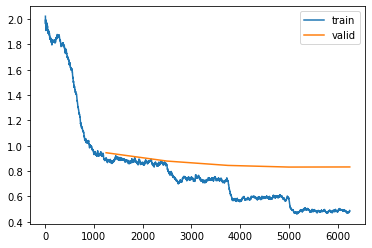

In [12]:
learn.recorder.plot_loss()

In [13]:
learn.dls.device

device(type='xla', index=1)

In [14]:
one_param(learn.model).device

device(type='xla', index=1)

### Interpretation

In [15]:
g = ratings.groupby("title")['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

In [16]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [17]:
mean_ratings = ratings.groupby("title")['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [18]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3621),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.3533), 'Grease 2 (1982)', 2.0),
 (tensor(-0.3267), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2898),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2861), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2621), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2582), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2516), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2414), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2362), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2327), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2308), 'Kansas City (1996)', 2.260869565217391),
 (tensor(-0.2289), 'Halloween: The Curse of Michael Myers (1995)', 2.2),
 (tensor(-0.2264), 'Airheads (1994)', 2.34375),
 (tensor(-0.2238),